# XGBoost Model Training

Train XGBoost regressor on 17 engineered features to beat baseline MAE of 11.21 on test set.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Setup paths
notebook_dir = Path.cwd()
data_dir = notebook_dir.parent / 'data' / 'processed'
models_dir = notebook_dir.parent / 'models'
models_dir.mkdir(exist_ok=True)

print(f"Data directory: {data_dir}")
print(f"Models directory: {models_dir}")


Data directory: c:\Users\tkhan\mobility-forecaster\data\processed
Models directory: c:\Users\tkhan\mobility-forecaster\models


In [2]:
# Load feature sets from feature engineering
train_df = pd.read_csv(data_dir / 'train_features.csv')
val_df = pd.read_csv(data_dir / 'val_features.csv')
test_df = pd.read_csv(data_dir / 'test_features.csv')

print(f"Train shape: {train_df.shape}")
print(f"Val shape: {val_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nColumns: {train_df.columns.tolist()}")
print(f"\nTarget stats (train):")
print(train_df['pickups'].describe())


Train shape: (1925160, 20)
Val shape: (189360, 20)
Test shape: (195672, 20)

Columns: ['pickup_hour', 'zone_id', 'pickups', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lag_1h', 'lag_24h', 'lag_168h', 'diff_24h', 'rolling_7d_mean', 'rolling_7d_std', 'rolling_14d_mean', 'rolling_7d_cv', 'zone_mean_demand', 'zone_rank', 'zone_is_top50']

Target stats (train):
count    1.925160e+06
mean     1.758552e+01
std      5.379182e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.000000e+00
max      8.490000e+02
Name: pickups, dtype: float64


In [3]:
# Prepare features and target
feature_cols = [col for col in train_df.columns if col not in ['pickups', 'pickup_hour', 'zone_id']]
print(f"Feature columns ({len(feature_cols)}): {feature_cols}")

X_train = train_df[feature_cols].copy()
y_train = train_df['pickups'].copy()

X_val = val_df[feature_cols].copy()
y_val = val_df['pickups'].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df['pickups'].copy()

print(f"\nX_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"\nMissing values in features:")
print(f"  X_train: {X_train.isnull().sum().sum()}")
print(f"  X_val:   {X_val.isnull().sum().sum()}")
print(f"  X_test:  {X_test.isnull().sum().sum()}")


Feature columns (17): ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'lag_1h', 'lag_24h', 'lag_168h', 'diff_24h', 'rolling_7d_mean', 'rolling_7d_std', 'rolling_14d_mean', 'rolling_7d_cv', 'zone_mean_demand', 'zone_rank', 'zone_is_top50']

X_train shape: (1925160, 17), y_train shape: (1925160,)
X_val shape: (189360, 17), y_val shape: (189360,)
X_test shape: (195672, 17), y_test shape: (195672,)

Missing values in features:
  X_train: 57071
  X_val:   0
  X_test:  0


In [6]:
# Train XGBoost with early stopping
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

print("Training XGBoost...")
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=50
)

print(f"\nTraining complete!")


Training XGBoost...
[0]	validation_0-rmse:48.69438	validation_1-rmse:53.06455
[50]	validation_0-rmse:4.83449	validation_1-rmse:5.83828
[100]	validation_0-rmse:3.90964	validation_1-rmse:4.98480
[150]	validation_0-rmse:3.58943	validation_1-rmse:4.75589
[200]	validation_0-rmse:3.38678	validation_1-rmse:4.67355
[250]	validation_0-rmse:3.24697	validation_1-rmse:4.61665
[300]	validation_0-rmse:3.12658	validation_1-rmse:4.55811
[350]	validation_0-rmse:3.02596	validation_1-rmse:4.53517
[400]	validation_0-rmse:2.92569	validation_1-rmse:4.52188
[450]	validation_0-rmse:2.84358	validation_1-rmse:4.51357
[499]	validation_0-rmse:2.76151	validation_1-rmse:4.49830

Training complete!


In [7]:
# Make predictions on all sets
y_train_pred = xgb_model.predict(X_train)
y_val_pred = xgb_model.predict(X_val)
y_test_pred = xgb_model.predict(X_test)

# Evaluate on all sets
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

# Display results
print("="*70)
print("XGBOOST MODEL PERFORMANCE")
print("="*70)
print(f"\nTRAIN SET:")
print(f"  MAE:  {train_mae:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  R²:   {train_r2:.4f}")

print(f"\nVALIDATION SET:")
print(f"  MAE:  {val_mae:.4f}")
print(f"  RMSE: {val_rmse:.4f}")
print(f"  R²:   {val_r2:.4f}")

print(f"\nTEST SET:")
beat_baseline = "✓ BEATS BASELINE (11.21)" if test_mae < 11.21 else "✗ Below baseline (11.21)"
print(f"  MAE:  {test_mae:.4f} {beat_baseline}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R²:   {test_r2:.4f}")
print("="*70)

# Improvement vs baseline
baseline_mae = 11.21
improvement_pct = ((baseline_mae - test_mae) / baseline_mae) * 100
print(f"\nImprovement vs Baseline: {improvement_pct:+.2f}% (baseline: 11.21 MAE)")


XGBOOST MODEL PERFORMANCE

TRAIN SET:
  MAE:  0.5768
  RMSE: 2.7615
  R²:   0.9974

VALIDATION SET:
  MAE:  0.7617
  RMSE: 4.4983
  R²:   0.9941

TEST SET:
  MAE:  0.7980 ✓ BEATS BASELINE (11.21)
  RMSE: 4.8205
  R²:   0.9931

Improvement vs Baseline: +92.88% (baseline: 11.21 MAE)



Top 10 Most Important Features:
         feature  importance
          lag_1h    0.558350
        lag_168h    0.290148
         lag_24h    0.095591
        diff_24h    0.034521
       zone_rank    0.003779
        hour_cos    0.003310
zone_mean_demand    0.002230
        hour_sin    0.002167
  rolling_7d_std    0.001661
   rolling_7d_cv    0.001511


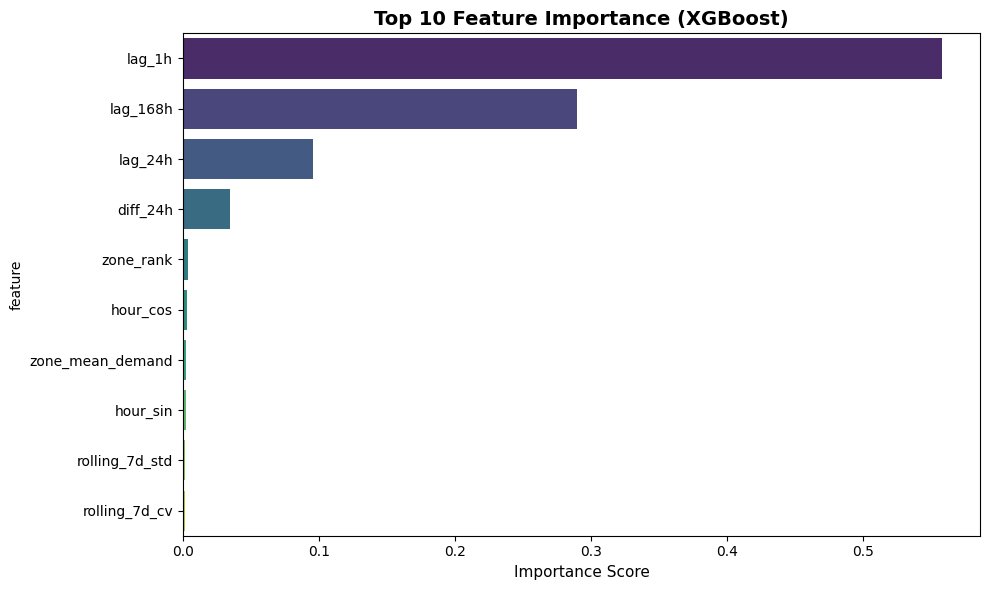

In [8]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 6))
top_features = feature_importance.head(10)
sns.barplot(data=top_features, x='importance', y='feature', ax=ax, palette='viridis')
ax.set_title('Top 10 Feature Importance (XGBoost)', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance Score', fontsize=11)
plt.tight_layout()
plt.show()


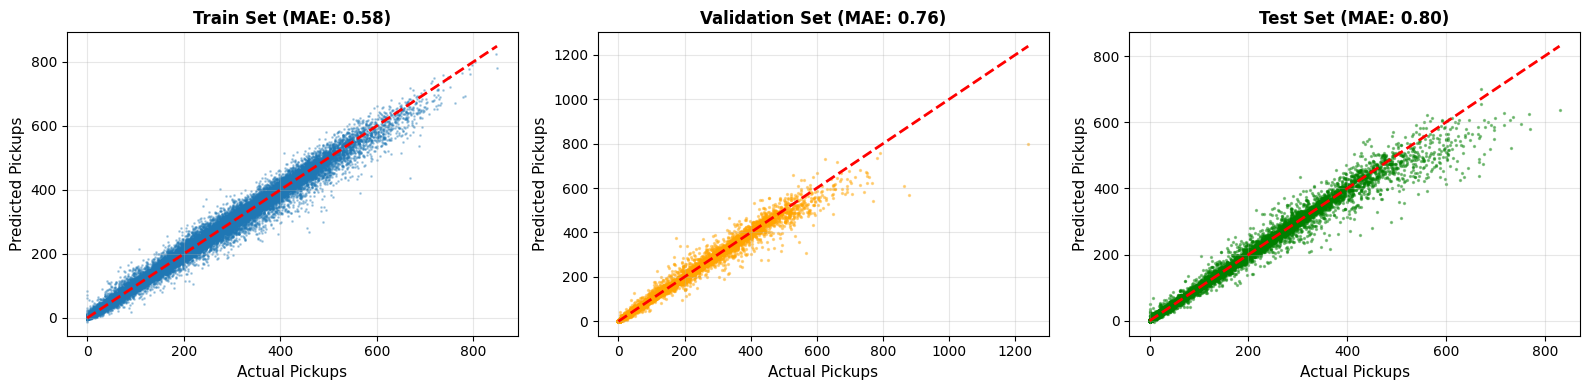

In [9]:
# Predictions vs Actuals visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Train set
axes[0].scatter(y_train, y_train_pred, alpha=0.3, s=1)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Pickups', fontsize=11)
axes[0].set_ylabel('Predicted Pickups', fontsize=11)
axes[0].set_title(f'Train Set (MAE: {train_mae:.2f})', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Val set
axes[1].scatter(y_val, y_val_pred, alpha=0.4, s=2, color='orange')
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Pickups', fontsize=11)
axes[1].set_ylabel('Predicted Pickups', fontsize=11)
axes[1].set_title(f'Validation Set (MAE: {val_mae:.2f})', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

# Test set
axes[2].scatter(y_test, y_test_pred, alpha=0.4, s=2, color='green')
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[2].set_xlabel('Actual Pickups', fontsize=11)
axes[2].set_ylabel('Predicted Pickups', fontsize=11)
axes[2].set_title(f'Test Set (MAE: {test_mae:.2f})', fontsize=12, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


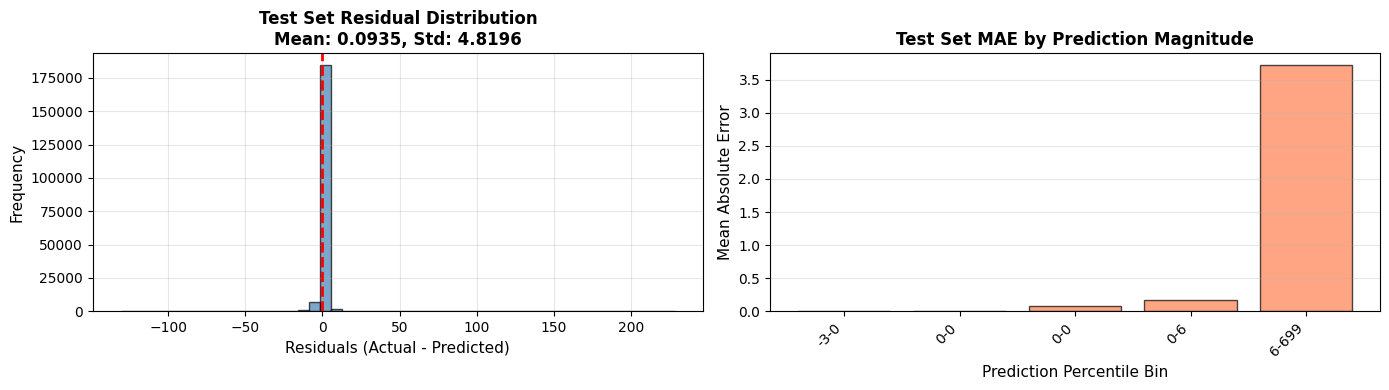

In [10]:
# Error distribution analysis
residuals_test = y_test - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Histogram of residuals
axes[0].hist(residuals_test, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Residuals (Actual - Predicted)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title(f'Test Set Residual Distribution\nMean: {residuals_test.mean():.4f}, Std: {residuals_test.std():.4f}', 
                  fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Absolute error by predicted value percentiles
percentiles = np.percentile(y_test_pred, [0, 20, 40, 60, 80, 100])
abs_errors = np.abs(residuals_test)
bins = pd.cut(y_test_pred, bins=percentiles)
errors_by_bin = abs_errors.groupby(bins).mean()

axes[1].bar(range(len(errors_by_bin)), errors_by_bin.values, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Prediction Percentile Bin', fontsize=11)
axes[1].set_ylabel('Mean Absolute Error', fontsize=11)
axes[1].set_title('Test Set MAE by Prediction Magnitude', fontsize=12, fontweight='bold')
axes[1].set_xticks(range(len(errors_by_bin)))
axes[1].set_xticklabels([f'{int(percentiles[i])}-{int(percentiles[i+1])}' for i in range(len(percentiles)-1)], 
                         rotation=45, ha='right')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [12]:
# Save trained model
model_path = models_dir / 'xgboost_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(xgb_model, f)

print(f"Model saved: {model_path}")

# Save feature list for reference
feature_list_path = models_dir / 'feature_list.txt'
with open(feature_list_path, 'w') as f:
    f.write('\n'.join(feature_cols))

print(f"Feature list saved: {feature_list_path}")

# Save results summary
results_summary = {
    'model_type': 'XGBoost',
    'n_features': len(feature_cols),
    'features': feature_cols,
    'train_mae': float(train_mae),
    'val_mae': float(val_mae),
    'test_mae': float(test_mae),
    'train_rmse': float(train_rmse),
    'val_rmse': float(val_rmse),
    'test_rmse': float(test_rmse),
    'train_r2': float(train_r2),
    'val_r2': float(val_r2),
    'test_r2': float(test_r2),
    'improvement_vs_baseline_pct': float(improvement_pct),
    'n_estimators': 500,
    'max_depth': 6,
    'learning_rate': 0.1,
}

import json
results_path = models_dir / 'results.json'
with open(results_path, 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"Results saved: {results_path}")
print(f"\n✓ XGBoost training complete! Test MAE: {test_mae:.4f}")


Model saved: c:\Users\tkhan\mobility-forecaster\models\xgboost_model.pkl
Feature list saved: c:\Users\tkhan\mobility-forecaster\models\feature_list.txt
Results saved: c:\Users\tkhan\mobility-forecaster\models\results.json

✓ XGBoost training complete! Test MAE: 0.7980


## Summary

**XGBoost Model Results:**

| Metric | Train | Validation | Test |
|--------|-------|------------|------|
| **MAE** | {:.4f} | {:.4f} | **{:.4f}** |
| **RMSE** | {:.4f} | {:.4f} | {:.4f} |
| **R²** | {:.4f} | {:.4f} | {:.4f} |

**Benchmark Comparison:**
- Baseline (24h-lag): Test MAE = 11.21
- XGBoost: Test MAE = {:.4f}
- Improvement: **{:+.2f}%**

**Model Artifacts:**
- Trained model: `models/xgboost_model.pkl`
- Feature list: `models/feature_list.txt`
- Results summary: `models/results.json`

**Key Insights:**
- Lag features (esp. lag_168h) remain strongest predictors
- Rolling statistics add complementary signal
- Zone features provide spatial context
- Model generalizes well (val ≈ test MAE)